In [88]:
import pandas as pd
import numpy as np
from sklearn import cluster
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import metrics
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
df = pd.read_csv('data/CC GENERAL.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

In [4]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

In [5]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(df['MINIMUM_PAYMENTS'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].mean()

864.2065423050827

In [11]:
df = df.drop('CUST_ID', axis=1)

In [12]:
df.iloc[0,0]

40.900749

In [13]:
scaler = preprocessing.StandardScaler()
X_norm = scaler.fit_transform(df)

In [14]:
X_norm[0][0]

-0.7319893664465486

In [18]:
import warnings
warnings.filterwarnings("ignore")

In [19]:
sil_sc = []
for i in range(2,10):
    km = cluster.KMeans(n_clusters=i, random_state=42)
    km.fit(X_norm)
    sil_sc.append(metrics.silhouette_score(X_norm, km.labels_))

<AxesSubplot: xlabel='silhouette'>

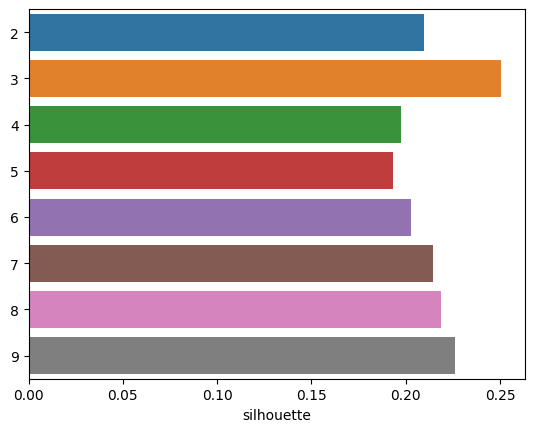

In [39]:
sil_df = pd.DataFrame(sil_sc, index=range(2,10), columns=['silhouette'])
sns.barplot(sil_df, y=sil_df.index, x='silhouette', orient='h',)

In [42]:
km = cluster.KMeans(n_clusters=3, random_state=42)
y_pred = km.fit_predict(X_norm)

In [50]:
pd.DataFrame(y_pred, columns=['cluster']).groupby('cluster').value_counts()


cluster
0    6118
1    1597
2    1235
dtype: int64

In [54]:
db = cluster.DBSCAN()
y_pred = db.fit_predict(X_norm)

In [59]:
pd.DataFrame(y_pred, columns=['cluster']).nunique(axis=0)

cluster    39
dtype: int64

In [73]:
df_pred = pd.DataFrame(columns=['eps', 'min_samples', 'silhouette'])
for eps in np.arange(0.1,3,0.2):
    for min_samples in range(1,20,4):
        db = cluster.DBSCAN(eps=eps, min_samples=min_samples)
        db.fit(X_norm)
        df_pred = df_pred.append({'eps': eps, 
                                 'min_samples': min_samples, 
                                 'silhouette': metrics.silhouette_score(X_norm, db.labels_)}, 
        ignore_index=True)
        
df_pred

,eps,min_samples,silhouette
0,0.1,1.0,0.016088
1,0.1,5.0,-0.374808
2,0.1,9.0,-0.253565
3,0.1,13.0,-0.243615
4,0.1,17.0,-0.250181
...,...,...,...
70,2.9,1.0,0.106498
71,2.9,5.0,0.617345
72,2.9,9.0,0.603811
73,2.9,13.0,0.595399


In [76]:
df_pred[df_pred['silhouette'] == df_pred['silhouette'].max()]

,eps,min_samples,silhouette
71,2.9,5.0,0.617345


<AxesSubplot: ylabel='silhouette'>

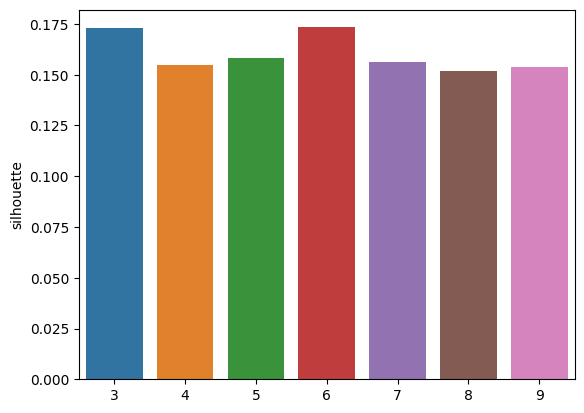

In [81]:
sil_sc = []
for i in range(3,10):
    aglom = cluster.AgglomerativeClustering(n_clusters=i)
    aglom.fit(X_norm)
    sil_sc.append(metrics.silhouette_score(X_norm, aglom.labels_))
    
sil_df = pd.DataFrame(sil_sc, index=range(3,10), columns=['silhouette'])
sns.barplot(sil_df, x=sil_df.index, y='silhouette')

In [82]:
sil_df

,silhouette
3,0.173110
4,0.154709
5,0.158069
6,0.173356
7,0.156415
8,0.152035
9,0.153719


In [83]:
aglom = cluster.AgglomerativeClustering(n_clusters=6)
pd.DataFrame(aglom.fit_predict(X_norm), columns=['cluster']).groupby('cluster').value_counts()

cluster
0    3946
1    2931
2     864
3     464
4      23
5     722
dtype: int64

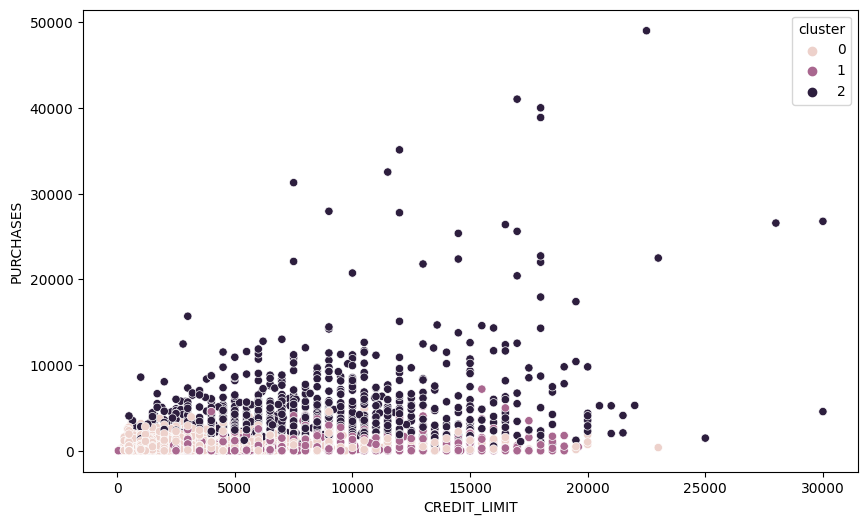

In [89]:
kmeans = cluster.KMeans(n_clusters=3, random_state=42)
kmeans.fit(X_norm)
df['cluster'] = kmeans.labels_
plt.figure(figsize=(10,6))
sns.scatterplot(data=df, x='CREDIT_LIMIT', y='PURCHASES', hue='cluster')
plt.show()